In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import math
import jsonlines

# dataframe globals
root = '/home/floh/Nextcloud/private/Projektchen/BA_data/csv_data/'
maincsv = 'mcgee_SAG-stats.csv'
stats_S4 = 'mcgee_s4.csv'
path_SAG = root + maincsv
path_S4 = root + stats_S4
path_json = "assembly_data_report.jsonl"
path_grates = "grates.csv"

fields_SAG = ['name', 'Sample_collection_Date (yymmdd)', 'estimated_diameter (µm)', 'Predicted_respiration_rate_fmol_O2_per_hr', 'GTDB_classification', 'GTDBtk_full_classification']
name, colldate, diameter, resprate, gtdbclass, gtdbfull = fields_SAG

fields_S4 = ['genus', 'GTDB_genus','#_of_cells', 'Proteorhodopsin encoded', 'Chlorophyll encoded']
genus_S4, gtdbgenus_s4, cellnr, prenc, chenc = fields_S4

strainrgx = rf"(g__[a-zA-Z0-9\-\_]*)\;"

# conversion utilimage.pngs
def diam2vol(celldiameter):
    return 1/6*math.pi*celldiameter**3
    
# dataframe prepping, read in df, remove NaN samples
def load_df(file, cfields):
    return (pd
        .read_csv(file, usecols=cfields)
    )

def addassembly_json(grates_path, json_path):
    df = pd.read_csv(grates_path, usecols=['Name', 'Assemblyname', 'd'])
    assemblystats=[[],[]]
    with jsonlines.open(json_path, mode='r') as file:
        for assembly in file:
            assemblystats[0].append(assembly['accession'])
            assemblystats[1].append(assembly['assemblyInfo']['biosample']['attributes'][7]['value'])
    df_assbm = pd.DataFrame({'Assemblyname': assemblystats[0], 'Name': assemblystats[1]})
    return (df
        .drop('Name', axis=1)
        .merge(df_assbm, how='left', left_on='Assemblyname', right_on='Assemblyname')
        .dropna(subset=['d'])
    )

######
# extracting and merging and prepping SAG and genus-data
# get dataframes
strainrgx = rf"f__([a-zA-Z0-9\-\_]*)\;"
df_SAG = (pd
            .read_csv(path_SAG, usecols=fields_SAG)
            .loc[lambda x: x[resprate].notna()]
            .assign(
                biovolume=lambda x: diam2vol(x[diameter]),
                resp_nm_bvol=lambda x: x[resprate]/x['biovolume'],
                family2=lambda x: x[gtdbfull].str.extract(strainrgx)
            )
        )
df_S4 = (pd
            .read_csv(path_S4, usecols=fields_S4)
            .dropna(how='all')
        )

df_mg = (df_SAG
            .merge(df_S4, how='left', left_on=gtdbclass, right_on=gtdbgenus_s4)
            .loc[lambda x: x[chenc] == "No"]
            .drop(columns=chenc)
            .assign(
                resp_med=lambda x: x[resprate].median(),
                resp_log=lambda x: x[resprate].transform(math.log),
                resp_nm_bvol_med=lambda x: x['resp_nm_bvol'].median(),
                resp_nm_bvol_log=lambda x: x['resp_nm_bvol'].transform(math.log)
            )
        )
df_grates = addassembly_json(path_grates, path_json)
df_mg = (df_mg
            .merge(df_grates, left_on='name', right_on='Name')
            .assign(
                grates_log=lambda x: x['d'].transform(math.log),
                resp_nm_bvol_gr=lambda x: x['resp_nm_bvol']/x['d'],
                resp_nm_bvol_gr_med=lambda x: x['resp_nm_bvol_gr'].median(),
                resp_nm_bvol_gr_log=lambda x: x['resp_nm_bvol_gr'].transform(math.log),
                resp_nm_gr=lambda x: x[resprate]/x['d'],
                resp_nm_gr_med=lambda x: x['resp_nm_gr'].median(),
                resp_nm_gr_log=lambda x: x['resp_nm_gr'].transform(math.log)
            )
        )

# Generating Growth rates from annotated genomic data
1. Obtain (meta-)genomic data
2. In addition, an attempt was made to also normalize for maximum growth rate via gRodon (citation -> Weissmann2021).

1920


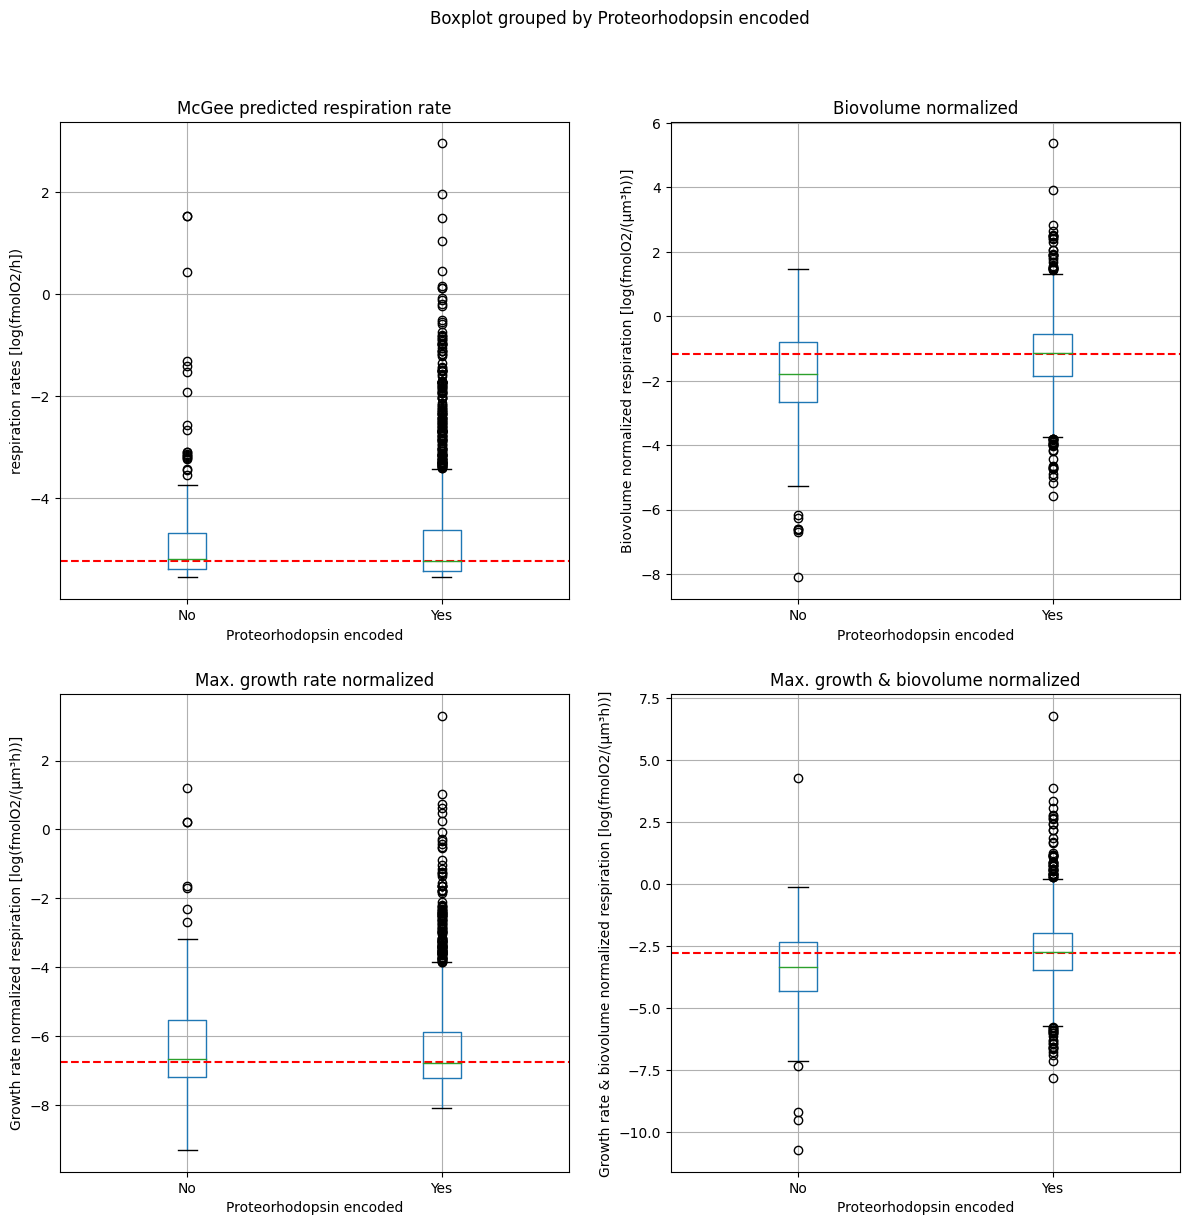

In [4]:

## Boxplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
df_mg.boxplot(column=['resp_log'], by=prenc, ax=axes[0,0])
df_mg.boxplot(column=['resp_nm_bvol_log'], by=prenc, ax=axes[0,1])
df_mg.boxplot(column=['resp_nm_gr_log'], by=prenc, ax=axes[1,0])
df_mg.boxplot(column=['resp_nm_bvol_gr_log'], by=prenc, ax=axes[1,1])

## Labelling etc.
axes[0,0].axhline(y = math.log(df_mg['resp_med'].iloc[0]), color = 'r', linestyle = '--')
axes[0,1].axhline(y = math.log(df_mg['resp_nm_bvol_med'].iloc[0]), color = 'r', linestyle = '--')
axes[1,0].axhline(y = math.log(df_mg['resp_nm_gr_med'].iloc[0]), color = 'r', linestyle = '--')
axes[1,1].axhline(y = math.log(df_mg['resp_nm_bvol_gr_med'].iloc[0]), color = 'r', linestyle = '--')
#
axes[0,0].set_title('McGee predicted respiration rate')
axes[0,1].set_title('Biovolume normalized')
axes[1,0].set_title('Max. growth rate normalized')
axes[1,1].set_title('Max. growth & biovolume normalized')
axes[0,0].set_ylabel('respiration rates [log(fmolO2/h])')
axes[0,1].set_ylabel('Biovolume normalized respiration [log(fmolO2/(µm³h))]')
axes[1,0].set_ylabel('Growth rate normalized respiration [log(fmolO2/(µm³h))]')
axes[1,1].set_ylabel('Growth rate & biovolume normalized respiration [log(fmolO2/(µm³h))]')

print(len(df_mg))
plt.show()

# Estimating max. growth rates from genomes
## 1. Get assembly names, download and extract annotated genome files
An extensive database is the one from National Center for Biotechnology Information (NCBI). [NCBI datasets](https://www.ncbi.nlm.nih.gov/datasets/) They offer a command line tool for downloading vast amounts of genomes in a short period of time as well as fine grained control over which data precisely is to be downloaded.As prediction methods based on CUB need annotations for highly expressed genes related to growth (?), this data has to be downloaded as well.
Munson-Mcgee 2022 provided uploaded their genomic data including highly expressed genes under Bioproject ID PRJNA846736. All data was downloaded as follows:
```bash
        ncbi-datasets download genome accession PRJNA846736 --include cds
```
### 1.1. paring isolate names with assembly names
Every ncbi dataset comes along with a database report in JSON-lines format (JSONL). All assemblies are stored separately from each other in their own folder, named with their respective assembly name, which makes it easy to iterate over the whole dataset. For a small number of genomes, information can easily be displayed using **jq**:
```bash
jq . ncbi_dataset/assembly_data_report.jsonl | head -n 180
```
+ `head -n INT` displays only the first n lines
Example output:
```json
{
  "accession": "GCA_028029375.1",
  "annotationInfo": {
    "method": "Best-placed reference protein set; GeneMarkS-2+",
    "name": "NCBI Prokaryotic Genome Annotation Pipeline (PGAP)",
    ...
  },
  "assemblyInfo": {
        ...
  }
}
```

## 2. Estimation of growth rates using gRodon2

Angepasster Code:
```R
# code adapted from https://github.com/jlw-ecoevo/gRodon2
library(gRodon)
library(Biostrings)

# obtain assemblynames (bash/other POSIX shell required)
file_list <- system("ls ncbi_dataset/data/ -1", intern = TRUE)

output-file <- "grates.csv"

# iterate over every assembly provided in the ncbi dataset
for (assemblyname in file_list) {
        cdsfile = noquote(paste("ncbi_dataset/data/",assemblyname,"/cds_from_genomic.fna", sep = ""))
        print(cdsfile)
        tryCatch({
                genes <- readDNAStringSet(cdsfile)
                # Search pre-existing annotations for ribosomal proteins, which we
                # will use as our set of highly expressed genes
                highly_expressed <- grepl("ribosomal protein",names(genes),ignore.case = T)
                output <- predictGrowth(genes, highly_expressed, mode="partial")
                # append Assembly name as well as estimated growth rate into as a list into csv file
                output <- c(list(Assemblyname = assemblyname), output)
                write.table(output, file=output-file, append=TRUE, quote=TRUE, sep=",", row.names=FALSE, col.names=FALSE)
        }, error = function(e) {
                print("Error")
                write.table(data.frame(element = assemblyname, fehlermeldung = e$message),
                file="errors.csv", append=TRUE, quote=TRUE, sep = ",", row.names = FALSE, col.names=FALSE)
        })
}
```

### 3.2 Sources for estimating cell parameters from genomic information:
+ **Weissmann 2021**: "Estimating max. microbial growth rates from cultures, metagenomes, and single cells via codon usage patterns"
    + providing open source tool "gRodon" for estimating growth rates from annotated genomes
    + improvement over growthpred and other tools
    + https://doi.org/10.1073/pnas.2016810118
+ **Long 2020**: "Benchmarking microbial growth rate predictions from metagenomes"
    + evaluating eifferent estimation methods, including CUB
    + maybe useful suppl. information
    + https://doi.org/10.1038/s41396-020-00773-1
+ **Weissmann 2022**: 
    + follow-up paper on Weissmann 2021
    + gRodon2: improved growth rates and corrections for mixed-species 
    + https://doi.org/10.1128/msystems.00745-22
    + dont't forget to cite related dependencies coRdon, Biostrings, matrixStats

also interesting to maybe look into in the future:
+ **Pachiadaki 2019**: "Charting the Complexity of the Marine Microbiome through Single-Cell Genomics"
    + estimating, among other things, cell sizes from single cell genomics
    + https://doi.org/10.1016/j.cell.2019.11.017
+ **Kirchmann 2016**: https://doi.org/10.1146/annurev-marine-122414-033938
+ **Vieira-Silva2010**: https://doi.org/10.1371/journal.pgen.1000808

## 4. load csv file as df into script and match with existing data
\# TODO